In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [2]:
# Calculates the bilateral filter convolution for a point
def bilateral_conv_point(image, x, y, filter_sz, sigma_s, sigma_r):
    # Generates sub-image centered at (x, y) with filter_sz
    c = (filter_sz-1)//2
    sub_image = image[x-c : x+c+1, y-c : y+c+1]

    # Gaussian Kernel
    kernel = lambda x, sigma : (1/(2*np.pi*sigma*sigma)) * np.exp(-(x*x)/(2*sigma*sigma))

    # Spatial Gaussian
    gaussian_s = [[np.linalg.norm(np.array((i, j)) - np.array((filter_sz//2, filter_sz//2))) for j in range(filter_sz)] for i in range(filter_sz)]
    gaussian_s = np.array([[kernel(x, sigma_s) for x in y] for y in gaussian_s])

    # Range Gaussian
    gaussian_r = [[sub_image[filter_sz//2, filter_sz//2] - sub_image[i, j] for j in range(filter_sz)] for i in range(filter_sz)]
    gaussian_r = np.array([[kernel(x, sigma_r) for x in y] for y in gaussian_r])

    # Multiplies both Gaussian filters
    filter = gaussian_s * gaussian_r

    # Gets the result by multiplying sub_image with filter and normalizing
    result = np.sum(sub_image * filter)
    result /= np.sum(filter)
    return result

# Calculates 2D convolution for the bilateral filter
def bilateral_conv_2d(image, filter_sz, sigma_s, sigma_r):
    # Creates matrix to put the resulting image and pads original image
    c = (filter_sz-1)//2
    res_image = np.empty(image.shape)
    image = np.pad(image, (c, c), 'constant', constant_values=(0))

    # Convoluting points for every point of the original image
    for i in range(image.shape[0]-2*c):
        for j in range(image.shape[1]-2*c):
            res_image[i, j] = bilateral_conv_point(image, i+c, j+c, filter_sz, sigma_s, sigma_r)

    # Crops the image to the original dimensions
    image = image[c : image.shape[0] - c , c : image.shape[1] - c]

    return res_image


In [3]:
# Calculates Laplacian filter from kernel type and parameter c
def laplacian_filter(image, kernel_type, c):
    # Creates kernel depending on user's choice
    if kernel_type == 1:
        kernel = np.array([ [0, -1, 0], [-1, 4, -1], [0, -1, 0] ])
    elif kernel_type == 2:
        kernel = np.array([ [-1, -1, -1], [-1, 8, -1], [-1, -1, -1] ])

    # Creates matrix to put resulting image and pads original image
    res_image = np.empty(image.shape)
    ce = 1
    image = np.pad(image, (ce, ce), 'constant', constant_values=(0))

    # Calculates convolution for each point of the image
    for i in range(image.shape[0]-2*ce):
        for j in range(image.shape[1]-2*ce):
            sub_image = image[i : i+2*ce+1, j : j+2*ce+1]
            res_image[i, j] = np.sum(sub_image * kernel)

    # Crop the image so it has the original dimensions
    image = image[ce : image.shape[0] - ce , ce : image.shape[1] - ce]

    # Normalize, calculates final result and normalize again
    res_image = (res_image - np.min(res_image)) * 255 / (np.max(res_image) - np.min(res_image))
    res_image = image + c*res_image
    res_image = (res_image - np.min(res_image)) * 255 / (np.max(res_image) - np.min(res_image))


    return res_image

In [4]:
# Calculates Vignette filter from sigma values
def vignette_filter(image, sigma_r, sigma_c):
    N, M = image.shape

    # Gaussian Kernel function
    kernel = lambda x, sigma : (1/(2*np.pi*sigma*sigma)) * np.exp(-(x*x)/(2*sigma*sigma))

    # Generating Guassian Kernels
    w_row = [i - N//2 for i in range(N)]
    w_row = np.array([np.array([kernel(x, sigma_r) for x in w_row])])
    w_row = w_row.transpose()

    w_col = [i - N//2 for i in range(M)]
    w_col = np.array([np.array([kernel(x, sigma_c) for x in w_col])])

    # Multiplying to obtain matrix with same dimensions of the image
    w = w_row.dot(w_col)

    # Getting the resulting image and normalizing
    res_image = w * image
    res_image = (res_image - np.min(res_image)) * 255 / (np.max(res_image) - np.min(res_image))

    return res_image

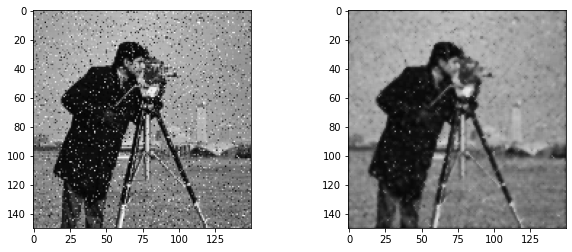

In [5]:
image1 = imageio.imread("images/camera.png").astype(np.float)

image1_f = bilateral_conv_2d(image1, 3, 150, 100).astype(np.uint8)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(image1, cmap="gray", vmin=0, vmax=255)
plt.subplot(132)
plt.imshow(image1_f, cmap="gray", vmin=0, vmax=255)

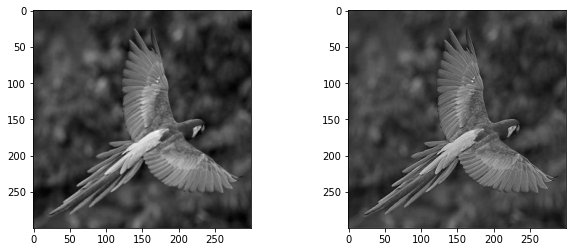

In [6]:
image2 = imageio.imread("images/arara.png").astype(np.float)
image2_f = laplacian_filter(image2, 1, 0.5).astype(np.uint8)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(image2, cmap="gray", vmin=0, vmax=255)
plt.subplot(132)
plt.imshow(image2_f, cmap="gray", vmin=0, vmax=255)

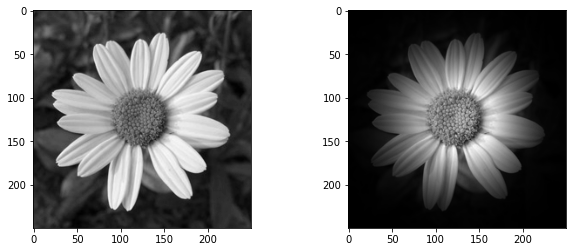

In [7]:
image3 = imageio.imread("images/flower.png").astype(np.float)
image3_f = vignette_filter(image3, 50, 50).astype(np.uint8)


plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(image3, cmap="gray", vmin=0, vmax=255)
plt.subplot(132)
plt.imshow(image3_f, cmap="gray", vmin=0, vmax=255)